<a id='contents'></a>

# Figures and analysis

This notebook contains scripts for producing the main figures and results accompanying the manuscript. Here we perform basic organization and processing of data, which is then passed to functions in figures.py (available at '/src' folder of this GitHub repository) for detailed formatting. The figures produced are stored as PDFs in the /figures folder.

## Contents

- [Overview and table of contents](#contents)
- [Loading libraries and global variables](#global)
- [Figures and data analysis](#figures)  
    - [Figure 1](#fig1)  
    - [Figure 2](#fig2)
    - [Figure 3](#fig3)
    - [Figure 4](#fig4)
    - [Figure 5](#fig5)
    - [Figure 6](#fig6)
    - [Figure 7](#fig7)
    - [Supplementary Figure 1](#figs1)
    - [Supplementary Figure 2](#figs2)
    - [Supplementary Figure 3](#figs3)
    - [Supplementary Figure 4](#figs4)
    - [Supplementary Figure 5](#figs5)
    - [Supplementary Figure 6](#figs6)
    - [Supplementary Figure 7](#figs7)

<a id='global'></a>

## Libraries and variables

In [1]:
# Full library list and version numbers

print('This notebook was prepared using:')

import sys, os
from copy import deepcopy
from importlib import reload
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy
import scipy.stats as stats
print('scipy version %s' % scipy.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plot
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
print('matplotlib version %s' % matplotlib.__version__)

import figures as fig
reload(fig)

# GLOBAL VARIABLES

N = 1000        # number of sequences in the population
L = 50          # sequence length
T = 700         # number of generations
MU = 1e-3       # mutation rate
num_selections = 10  # number of sets of selection coefficients that we used
num_trials = 20  # for each set of selection coefficients, we simulated for 20 times
SAMPLE = [1000, 500, 100, 50, 10]  # sampling depth options when subsampling
RECORD = [1, 3, 5, 10]  # sampling time interval options when subsampling
LINEAR = [1, 5, 10, 20, 50, 100, 300]  # list of linear shrinkage strengths/sampling time intervals, e.g., interval=5, linear=5 ==> strength=25'
GAMMA = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]  # non-linear shrinkage parameter choices that we tested
TRUNCATE = [200, 300, 400, 500, 600, 700]  # truncate options to test performance using different lengths of data
WINDOW = [0, 1, 2, 3, 4, 5, 10, 20, 40, 80, 160]  # window choices that we tested
# loss functions for non-linear shrinkage that we tested
LOSS = ['Fro | $\hat{C}-C$', 'Fro | $\hat{C}^{-1}-C^{-1}$', 'Fro | $C^{-1}\hat{C}-I$', 
        'Fro | $\hat{C}^{-1}C-I$', 'Fro | $\hat{C}^{-1/2}C\hat{C}^{-1/2}-I$', 
        'Nuc | $\hat{C}-C$', 'Nuc | $\hat{C}^{-1}-C^{-1}$', 'Nuc | $C^{-1}\hat{C}-I$', 
        'Nuc | $\hat{C}^{-1}C-I$', 'Nuc | $\hat{C}^{-1/2}C\hat{C}^{-1/2}-I$']

# GitHub directories
FIG_DIR = './figures'
HIV_DIR = 'data/HIV'
SELECTION_DIR = './src/selection'
INITIAL_DIR = './src/initial'
SIMULATION_OUTPUT_DIR = './data/simulation_output'
SUBSAMPLE_OUTPUT_DIR = './data/subsample_output'
ESTIMATION_OUTPUT_DIR = './data/estimation_output'

This notebook was prepared using:
python version 3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 18:53:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.19.1
scipy version 1.5.2
pandas version 1.1.3
matplotlib version 3.3.2


<a id='figures'></a>

## Figures and data analysis

<a id='fig1'></a>

### Figure 1. Linkage information is accurately recovered from trajectories of mutant allele frequencies exhibiting complex dynamics in a WF simulation.

In [2]:
def load_selection(s):
    """Loads one of 10 sets of selection coefficients."""
    
    return np.load(SELECTION_DIR + f'/selection_{s}.npy')


def load_traj_example(s, n, p=0, q=0, tr=5):
    """Loads allele frequency trajectories of one particular simulation.
    
    Args:
        s: 0 ~ 9, indicating one of 10 sets of selection coefficients.
        n: 0 ~ 19, indicating one of 20 trials.
        p: 0 ~ 4, indicating one of 5 sampling depths.
        q: 0 ~ 3, indicating one of 3 sampling time intervals.
        tr: 0 ~ 5, indicating one of 6 truncating lengths.
    """
    
    if p == 0 and q == 0:
        dic = np.load(SIMULATION_OUTPUT_DIR + f'/simulation_output_s={s}_n={n}.npz')
    else:
        dic = np.load(SUBSAMPLE_OUTPUT_DIR + f'/subsample_output_s={s}_n={n}_sample={SAMPLE[p]}_record={RECORD[q]}.npz')
    traj = dic['traj'][:TRUNCATE[tr] + 1]
    return traj


def load_cov_example(s=4, n=0, tr=5, window=20, sample_selected=0, record_selected=0):
    """Loads intgrated covariances with a certain data length and a certain window choice."""
    
    dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={TRUNCATE[tr]}_window={window}.npz')
    
    if dic['size'] == 'minimal':
        return dic['int_cov'][s], dic['int_dcov'][s], dic['int_dcov_uncalibrated'][s]
    elif dic['size'] == 'medium':
        return dic['int_cov'][s, n], dic['int_dcov'][s, n], dic['int_dcov_uncalibrated'][s, n]
    else: # dic['size'] == 'complete'
        return dic['int_cov'][s, n, p, q], dic['int_dcov'][s, n, p, q], dic['int_dcov_uncalibrated'][s, n, p, q]
   


In [3]:
s, n = 4, 0
traj = load_traj_example(s, n)
selection = load_selection(s)
true_cov, est_cov, est_cov_unnormalized = load_cov_example(s=s, n=n, tr=5, window=20)
print(true_cov[0, :5])
print(est_cov[0, :5])

[40.71443167 -0.52433617  3.01239767  0.61594417 -0.4301295 ]
[40.674197   -0.47030615  3.38967681  0.39239346 -1.18023851]


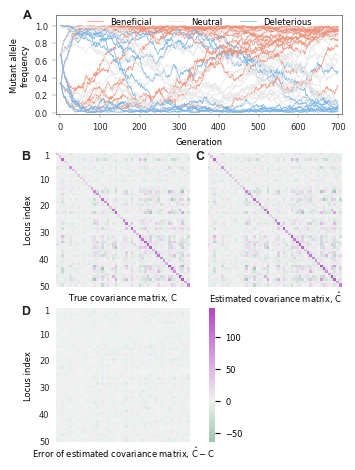

In [4]:
reload(fig)
fig.plot_figure_traj_cov_example(traj, selection, true_cov, est_cov, 
    save_file=FIG_DIR + "/fig-traj-cov-example.pdf")

<a id='fig2'></a>

### Figure 2. Normalization and choosing a proper time window are important to accurate estimation of linkage information.

In [5]:
def load_cov_one_for_each_selection(tr=5, n=0, window=20, sample_selected=0, record_selected=0):
    """Loads intgrated covarianc matrices with a certain data length and a certain window choice."""
    
    dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={TRUNCATE[tr]}_window={window}.npz')
    
    if dic['size'] == 'minimal':
        return dic['int_cov'], dic['int_dcov'], dic['int_dcov_uncalibrated']
    elif dic['size'] == 'medium':
        return dic['int_cov'][:, n], dic['int_dcov'][:, n], dic['int_dcov_uncalibrated'][:, n]
    else: # dic['size'] == 'complete'
        return dic['int_cov'][:, n, p, q], dic['int_dcov'][:, n, p, q], dic['int_dcov_uncalibrated'][:, n, p, q]
    

def load_cov_error_with_various_windows(tr=5, n=0, window_list=WINDOW, sample_selected=0, record_selected=0, metric_index=0):
    """Loads MAE error of estimated covarianc matrices with a certain data length and various windows.
    
    Args:
        metrics_index: 0, 1, or 2
            0 stores MAE of all entries in covariance matrices (both covariances and variances).
            1 stores MAE of off-diagonal entries in covariance matrices (only covariances).
            2 stores MAE of diagonal entries in covariance matrices (only variances).
    """
    
    dic_list = [np.load(ESTIMATION_OUTPUT_DIR + 
                        f'/estimation_output_truncate={TRUNCATE[tr]}_window={window}.npz') 
                for window in window_list]
    
    return (np.array([dic['error_cov_calibrated'][:, n, sample_selected, record_selected, metric_index] for dic in dic_list]), 
            np.array([dic['error_cov_uncalibrated'][:, n, sample_selected, record_selected, metric_index] for dic in dic_list]))
    

In [6]:
tr, n, window = 5, 0, 20
(true_cov_all, est_cov_all, 
 est_cov_unnormalized_all) = load_cov_one_for_each_selection(tr=tr, n=n, window=window)
(error_normalized_window, 
 error_unnormalized_window) = load_cov_error_with_various_windows(tr=tr, n=n)

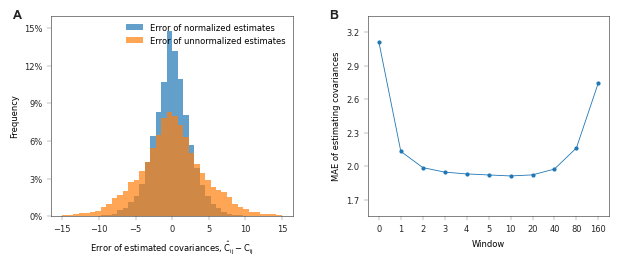

In [7]:
reload(fig)
fig.plot_figure_performance_estimation_normalization_window(
    true_cov_all, est_cov_all, est_cov_unnormalized_all, 
    error_normalized_window,
    save_file=FIG_DIR + "/fig-cov-hist-norm-window-double.pdf")


<a id='fig3'></a>

### Figure 3.  Estimated covariance can improve inference of selection coefficients with ample data.

In [8]:
def load_performance(window=20):
    """Loads spearmanr & error of inferred selections with a certain window choice."""
    
    # cov
    spearmanr_cov_normalized = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), 3), dtype=float)
    error_cov_normalized = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), 3), dtype=float)
    spearmanr_cov_unnormalized = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), 3), dtype=float)
    error_cov_unnormalized = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), 3), dtype=float)
    
    # SL, MPL, est & est(unnormalized)
    num_basic = 4
    spearmanr_basic = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)
    error_basic = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)

    # linear shrinkage on covariance
    spearmanr_linear = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)
    error_linear = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)

    # non-linear shrinkage on correlation
    spearmanr_dcorr = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    error_dcorr = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    
    for tr, truncate in enumerate(TRUNCATE):
        dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={truncate}_window={window}.npz')
        spearmanr_cov_normalized[tr] = dic['spearmanr_cov_calibrated']
        error_cov_normalized[tr] = dic['error_cov_calibrated']
        spearmanr_cov_unnormalized[tr] = dic['spearmanr_cov_uncalibrated']
        error_cov_unnormalized[tr] = dic['error_cov_uncalibrated']
        
        spearmanr_basic[tr] = dic['spearmanr_basic']
        spearmanr_linear[tr] = dic['spearmanr_linear']
        spearmanr_dcorr[tr] = dic['spearmanr_dcorr']
        error_basic[tr] = dic['error_basic']
        error_linear[tr] = dic['error_linear']
        error_dcorr[tr] = dic['error_dcorr']

    return (spearmanr_cov_normalized, spearmanr_cov_unnormalized, spearmanr_basic, spearmanr_linear, spearmanr_dcorr,
            error_cov_normalized, error_cov_unnormalized, error_basic, error_linear, error_dcorr)

In [9]:
(spearmanr_cov_normalized, spearmanr_cov_unnormalized, 
 spearmanr_basic, spearmanr_linear, spearmanr_dcorr,
 error_cov_normalized, error_cov_unnormalized, 
 error_basic, error_linear, error_dcorr) = load_performance(window=20)

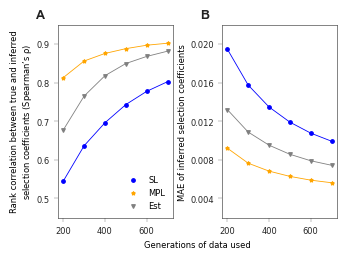

In [10]:
reload(fig)
fig.plot_figure_performance_with_ample_data(
    spearmanr_basic, error_basic, truncate_list=TRUNCATE, arrange_vertically=False,
    save_file=FIG_DIR + "/fig-performance-ample-data.pdf")

<a id='fig4'></a>

### Figure 4. Performance is robust to sampling depth but sensitive to sampling time interval.

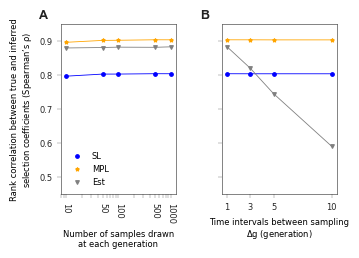

In [11]:
reload(fig)
fig.plot_figure_performance_with_limited_data(
    spearmanr_basic, truncate_index=5, 
    truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
    save_file=FIG_DIR + "/fig-performance-limited-data.pdf")

<a id='fig5'></a>

### Figure 5. A proper strength of linear shrinkage can improve performance un-der limited sampling effects.

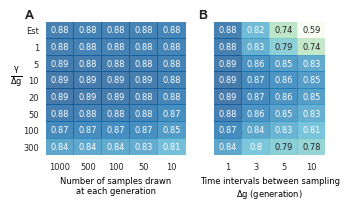

In [12]:
reload(fig)
fig.plot_figure_performance_with_linear_shrinkage(
    spearmanr_basic, spearmanr_linear, truncate_index=5, 
    truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, linear_list=LINEAR, 
    save_file=FIG_DIR + "/fig-performance-linear-shrinkage.pdf")

<a id='fig6'></a>

### Figure 6. Performance can be greatly improved by combining data from multiple replicates.

In [13]:
def load_performance_combine(window=20):
    """Loads spearmanr & error of inferred selections by combining multiple replicates with a certain window choice."""
    
    # SL, MPL, est & est(uncalibrated)
    num_basic = 4
    spearmanr_basic_combine = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)
    error_basic_combine = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)

    # linear shrinkage on covariance
    spearmanr_linear_combine = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)
    error_linear_combine = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LINEAR)), dtype=float)

    # non-linear shrinkage on correlation
    spearmanr_dcorr_combine = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    error_dcorr_combine = np.zeros((len(TRUNCATE), num_selections, num_trials, len(SAMPLE), len(RECORD), len(LOSS), len(GAMMA)), dtype=float)
    
    for tr, truncate in enumerate(TRUNCATE):
        dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={truncate}_window={window}.npz')
        spearmanr_basic_combine[tr] = dic['spearmanr_basic_combine']
        spearmanr_linear_combine[tr] = dic['spearmanr_linear_combine']
        spearmanr_dcorr_combine[tr] = dic['spearmanr_dcorr_combine']
        error_basic_combine[tr] = dic['error_basic_combine']
        error_linear_combine[tr] = dic['error_linear_combine']
        error_dcorr_combine[tr] = dic['error_dcorr_combine']

    return (spearmanr_basic_combine, spearmanr_linear_combine, spearmanr_dcorr_combine,
            error_basic_combine, error_linear_combine, error_dcorr_combine)

In [14]:
(spearmanr_basic_combine, spearmanr_linear_combine, 
 spearmanr_dcorr_combine, error_basic_combine, 
 error_linear_combine, error_dcorr_combine) = load_performance_combine(window=20)

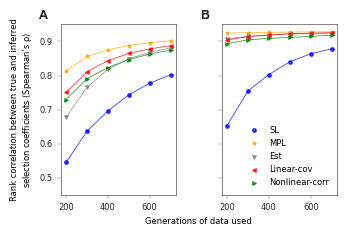

In [15]:
reload(fig)
fig.plot_figure_performance_combining_multiple_replicates(
    spearmanr_basic, spearmanr_linear, spearmanr_dcorr, 
    spearmanr_basic_combine, spearmanr_linear_combine, spearmanr_dcorr_combine, 
    truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
    linear_selected=2, loss_selected=3, gamma_selected=0,
    save_file=FIG_DIR + "/fig-performance-combining-replicates.pdf")

<a id='fig7'></a>

### Figure 7. Performance  improves  as  the  number  of  combined  replicates  increases.

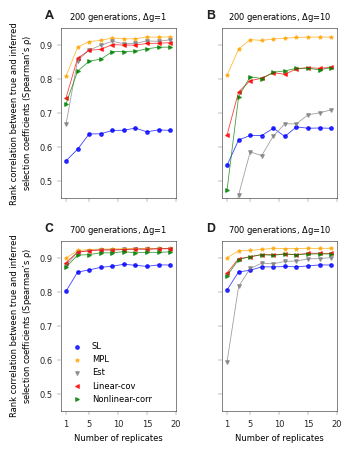

In [16]:
reload(fig)
fig.plot_figure_performance_combining_different_numbers_of_replicates(
    spearmanr_basic_combine, spearmanr_linear_combine, spearmanr_dcorr_combine, 
    truncate_list=TRUNCATE, num_basic=3, # not plotting unnormalized results
    sample_list=SAMPLE, record_list=RECORD, linear_selected=2, loss_selected=3, gamma_selected=0,
    double_column=False,
    save_file=FIG_DIR + "/fig-performance-number-of-replicates.pdf")

<a id='figs1'></a>

### Supplementary Fig 1. Uniform and bimodal distributions are used to generate 10 sets of selection coefficients used in simulations.

In [17]:
def load_selections():
    """Loads 10 sets of selection coefficients used in simulations."""
    
    selections = np.zeros((num_selections, L), dtype=float)
    for s in range(num_selections):
        selections[s] = np.load(SELECTION_DIR + f'/selection_{s}.npy')
    return selections

In [18]:
selections = load_selections()

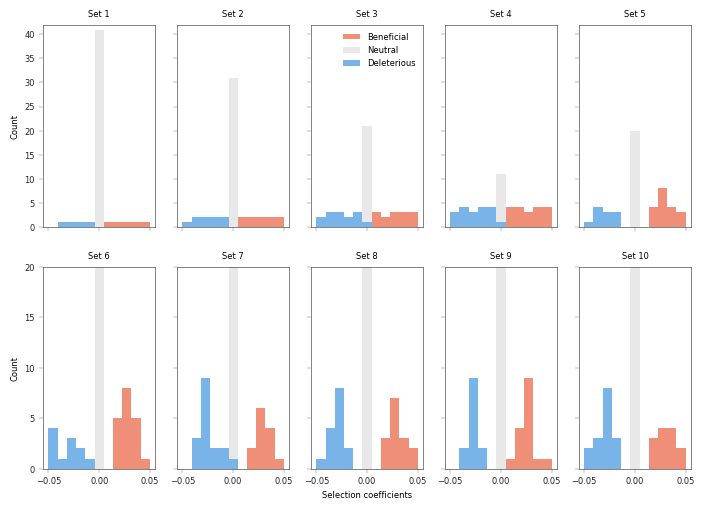

In [19]:
reload(fig)
fig.plot_supplementary_figure_selections(selections, alpha=1, 
    save_file=FIG_DIR + "/figs-selection-coefficients.pdf")

<a id='figs2'></a>

### Supplementary Fig 2. Regularization restrains large terms in the inverse of estimated covariance matrix.

In [20]:
def load_complete_cov_for_a_simulation(s=4, n=0, tr=5, window=20, linear_selected=2):
    """Loads different estimates of intgrated covariances.
    Note: require complete output. 
    """
    
    dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={TRUNCATE[tr]}_window={window}_complete.npz')
    if dic['size'] != 'complete':
        print(f'Output does not contain complete covariance information.')
        return
    keys = ['int_cov', 'int_dcov', 'int_dcov_uncalibrated', 'int_dcov_dcorr_reg', 'int_dcov_uncalibrated_dcorr_reg']
    
    dic_cov = {key: dic[key][s, n] for key in keys}
    L = len(dic_cov['int_cov'][0, 0])
    linear_reg = LINEAR[linear_selected]
    dic_cov['int_dcov_linear'] = dic_cov['int_dcov'] + linear_reg * np.identity(L)
    dic_cov['int_dcov_uncalibrated_linear'] = dic_cov['int_dcov_uncalibrated'] + linear_reg * np.identity(L)
    return dic_cov

In [21]:
tr, window = 5, 20
s, n = 4, 0
dic_cov = load_complete_cov_for_a_simulation(s=s, n=n, tr=tr, window=window)
selection = load_selection(s)

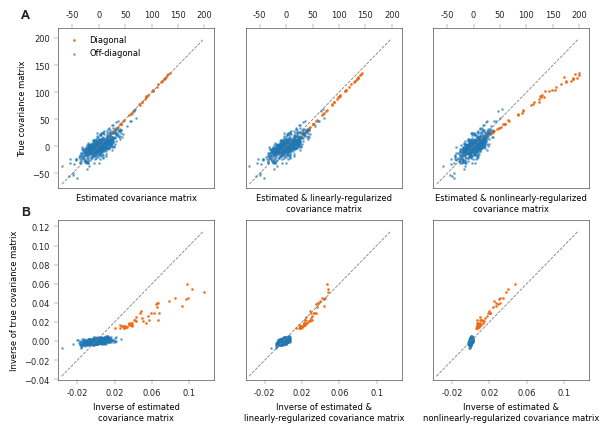

In [22]:
reload(fig)
p, q = 2, 3
fig.plot_supplementary_figure_biplot_cov(
    dic_cov['int_cov'][p, q], dic_cov['int_dcov'][p, q], 
    dic_cov['int_dcov_linear'][p, q], dic_cov['int_dcov_dcorr_reg'][p, q], 
    xticks_top=[-50, 0, 50, 100, 150, 200], xticks_bottom=[-0.02, 0.02, 0.06, 0.1],
    save_file=FIG_DIR + "/figs-covariance-regularization-biplot.pdf")

<a id='figs3'></a>

### Supplementary Fig 3.  Normalization improves performances of both estimating covariance and inferring selection.

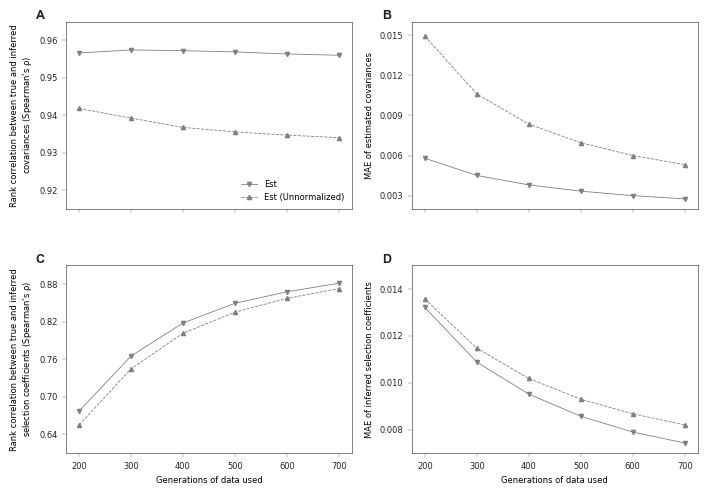

In [23]:
reload(fig)
fig.plot_supplementary_figure_performance_with_without_normalization(
    spearmanr_basic, error_basic, spearmanr_cov_normalized, error_cov_normalized, 
    spearmanr_cov_unnormalized, error_cov_unnormalized, truncate_list=TRUNCATE, 
    save_file=FIG_DIR + "/figs-performance-normalization.pdf")

<a id='figs4'></a>

### Supplementary Fig 4.   Performance improves with larger time windows.

In [24]:
def load_performance_window(truncate=700, linear_selected=2, loss_selected=3, gamma_selected=0):
    """Loads Spearmanr & error of inferred selections with different time window choices."""
    
    # SL, MPL, est & est(uncalibrated)
    num_basic = 4
    spearmanr_basic_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)
    error_basic_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD), num_basic), dtype=float)

    # linear shrinkage on covariance
    spearmanr_linear_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)
    error_linear_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)

    # non-linear shrinkage on correlation
    spearmanr_dcorr_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)
    error_dcorr_window = np.zeros((len(WINDOW), num_selections, num_trials, len(SAMPLE), len(RECORD)), dtype=float)
    
    for wi, window in enumerate(WINDOW):
        dic = np.load(ESTIMATION_OUTPUT_DIR + f'/estimation_output_truncate={truncate}_window={window}.npz')
        spearmanr_basic_window[wi] = dic['spearmanr_basic']
        spearmanr_linear_window[wi] = dic['spearmanr_linear'][:, :, :, :, linear_selected]
        spearmanr_dcorr_window[wi] = dic['spearmanr_dcorr'][:, :, :, :, loss_selected, gamma_selected]
        error_basic_window[wi] = dic['error_basic']
        error_linear_window[wi] = dic['error_linear'][:, :, :, :, linear_selected]
        error_dcorr_window[wi] = dic['error_dcorr'][:, :, :, :, loss_selected, gamma_selected]

    return (spearmanr_basic_window, spearmanr_linear_window, spearmanr_dcorr_window,
            error_basic_window, error_linear_window, error_dcorr_window)

In [25]:
(spearmanr_basic_window, spearmanr_linear_window, spearmanr_dcorr_window,
 error_basic_window, error_linear_window, error_dcorr_window
) = load_performance_window(truncate=700, linear_selected=2, loss_selected=3, gamma_selected=0)

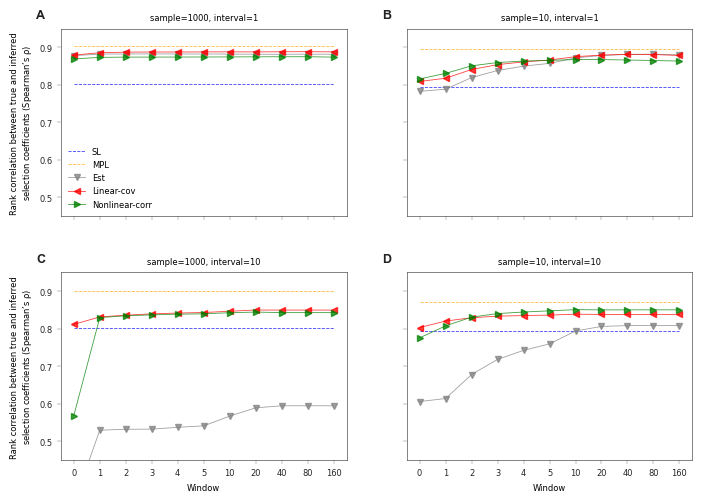

In [26]:
reload(fig)
fig.plot_supplementary_figure_performance_with_different_time_window(
    spearmanr_basic_window, spearmanr_linear_window, spearmanr_dcorr_window, 
    window_list=WINDOW, record_list=RECORD, max_q=3, max_p=4, 
    uncalibrated=False, ylim=(0.45, 0.95), alpha=0.75,
    save_file=FIG_DIR + "/figs-performance-time-window.pdf")

In [27]:
# MAE of inferred selections with different windows (not included in Supplementary Information)
# reload(fig)
# fig.plot_supplementary_figure_performance_with_different_time_window(
#     error_basic_window, error_linear_window, error_dcorr_window, 
#     window_list=WINDOW, ylim=(0.005, 0.025), 
#     ylabel='MAE of inferred selection coefficients', save_file=None)

<a id='figs5'></a>

### Supplementary Fig 5.   Nonlinear shrinkage performs best with a small regularization strength $\eta$.

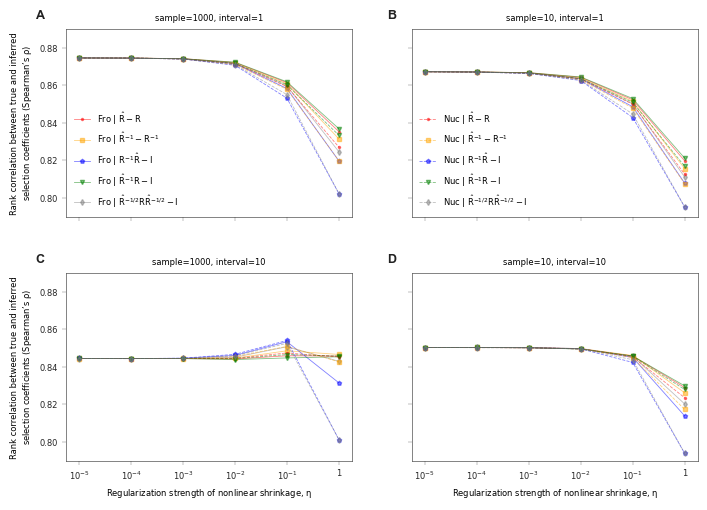

In [28]:
reload(fig)
fig.plot_supplementary_figure_performance_with_different_loss_gamma(
    spearmanr_dcorr, truncate_index=5,
    save_file=FIG_DIR + "/figs-performance-gamma-loss.pdf")

<a id='figs6'></a>

### Supplementary Fig 6.  Spearman's $\rho$ of all tested methods.

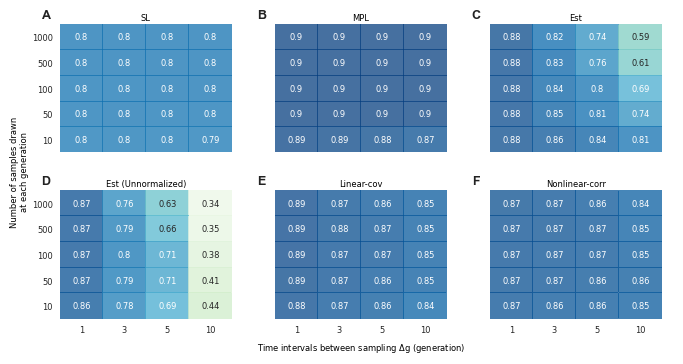

In [29]:
reload(fig)
fig.plot_supplementary_figure_performance_all_methods(spearmanr_basic, spearmanr_linear, spearmanr_dcorr, 
    truncate_index=5, truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
    loss_selected=3, gamma_selected=0, linear_selected=2, vmin=0.3, vmax=0.9,
    save_file=FIG_DIR + "/figs-Spearmanr-all-methods.pdf")



<a id='figs7'></a>

### Supplementary Fig 7.   MAE of inferred selections of all tested methods.

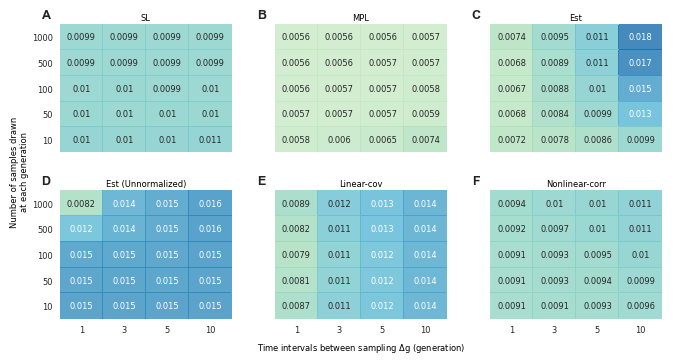

In [30]:
reload(fig)
fig.plot_supplementary_figure_performance_all_methods(error_basic, error_linear, error_dcorr, 
    truncate_index=5, truncate_list=TRUNCATE, sample_list=SAMPLE, record_list=RECORD, 
    loss_selected=3, gamma_selected=0, linear_selected=2, vmin=0, vmax=0.02,
    save_file=FIG_DIR + "/figs-MAE-all-methods.pdf")

